## **패키지 설치 및 라이브러리 구성**

In [88]:
!pip install catboost
!pip install category_encoders

You should consider upgrading via the '/opt/conda/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.8 -m pip install --upgrade pip' command.


In [89]:
#SMOTE 설치
!pip install scikit-learn==0.23.1
!pip install imbalanced-learn==0.7.0

  Using cached scikit_learn-0.23.1-cp38-cp38-manylinux1_x86_64.whl (6.7 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.1.1
    Uninstalling scikit-learn-1.1.1:
      Successfully uninstalled scikit-learn-1.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-ml 2021.11.30 requires numpy>=1.20.0, but you have numpy 1.19.5 which is incompatible.
dask-ml 2021.11.30 requires scikit-learn>=1.0.0, but you have scikit-learn 0.23.1 which is incompatible.
autokeras 1.0.16.post1 requires keras-tuner<1.1,>=1.0.2, but you have keras-tuner 1.1.0 which is incompatible.
autokeras 1.0.16.post1 requires tensorflow<2.6,>=2.3.0, but you have tensorflow 2.7.0 which is incompatible.
You should consider upgrading via the '/opt/conda/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin

In [90]:
pip install kmodes

You should consider upgrading via the '/opt/conda/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [91]:
pip install matplotlib

You should consider upgrading via the '/opt/conda/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [92]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, random
warnings.filterwarnings(action='ignore')

from catboost import CatBoostClassifier, Pool
# from lightgbm import LGBMClassifier, plot_importance
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import silhouette_score
from sklearn.metrics import log_loss, accuracy_score, auc, confusion_matrix, roc_auc_score ,roc_curve,auc, f1_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from kmodes.kprototypes import KPrototypes

from imblearn.over_sampling import SMOTENC, SMOTE, BorderlineSMOTE, ADASYN
from collections import Counter

from tqdm.notebook import tqdm
import time

## **데이터 불러오기**

In [93]:
train = pd.read_csv('before_engineering_train.csv')
test = pd.read_csv('before_engineering_test.csv')

In [95]:
test.describe()

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month,credit
count,7446.000000,7.446000e+03,7446.000000,7446.000000,7446.000000,7446.000000,7446.000000,7446.000000,7446.000000,7446.000000
mean,0.440774,1.866557e+05,15935.552914,2170.822186,0.223341,0.290492,0.090787,2.213269,26.311980,1.524846
std,0.737682,9.993040e+04,4187.426368,2340.302100,0.416513,0.454020,0.287325,0.907645,16.471268,0.698545
min,0.000000,2.925000e+04,7757.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,1.215000e+05,12454.000000,415.000000,0.000000,0.000000,0.000000,2.000000,12.000000,1.000000
50%,0.000000,1.575000e+05,15519.000000,1536.000000,0.000000,0.000000,0.000000,2.000000,25.000000,2.000000
75%,1.000000,2.250000e+05,19431.000000,3111.000000,0.000000,1.000000,0.000000,3.000000,39.750000,2.000000
max,5.000000,1.575000e+06,24970.000000,15661.000000,1.000000,1.000000,1.000000,7.000000,60.000000,2.000000


In [96]:
y_test = test['credit']
test.drop(columns='credit', axis=1, inplace=True)

In [97]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17371 entries, 0 to 17370
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         17371 non-null  object 
 1   car            17371 non-null  object 
 2   reality        17371 non-null  object 
 3   child_num      17371 non-null  int64  
 4   income_total   17371 non-null  float64
 5   income_type    17371 non-null  object 
 6   edu_type       17371 non-null  object 
 7   family_type    17371 non-null  object 
 8   house_type     17371 non-null  object 
 9   DAYS_BIRTH     17371 non-null  int64  
 10  DAYS_EMPLOYED  17371 non-null  int64  
 11  work_phone     17371 non-null  int64  
 12  phone          17371 non-null  int64  
 13  email          17371 non-null  int64  
 14  occyp_type     17371 non-null  object 
 15  family_size    17371 non-null  float64
 16  begin_month    17371 non-null  float64
 17  credit         17371 non-null  float64
dtypes: flo

## **Feature Engineering**

### **파생변수 생성**
* numeric 변수는 최대한 다양한 특징을 보일 수 있도록 생성
* category 변수는 여러가지를 조합해 보았지만 전체 변수를 합친 ID 하나만 만들었을 때 가장 logloss가 낮았음

In [98]:
for df in [train,test]:
  # before_EMPLOYED: 고용되기 전까지의 일수
  df['before_EMPLOYED'] = df['DAYS_BIRTH'] - df['DAYS_EMPLOYED']
  df['income_total_befofeEMP_ratio'] = df['income_total'] / df['before_EMPLOYED']
  df['before_EMPLOYED_m'] = np.floor(df['before_EMPLOYED'] / 30) - ((np.floor(df['before_EMPLOYED'] / 30) / 12).astype(int) * 12)
  df['before_EMPLOYED_w'] = np.floor(df['before_EMPLOYED'] / 7) - ((np.floor(df['before_EMPLOYED'] / 7) / 4).astype(int) * 4)

  #DAYS_BIRTH 파생변수- Age(나이), 태어난 월, 태어난 주(출생연도의 n주차)
  df['Age'] = df['DAYS_BIRTH'] // 365
  df['DAYS_BIRTH_m'] = np.floor(df['DAYS_BIRTH'] / 30) - ((np.floor(df['DAYS_BIRTH'] / 30) / 12).astype(int) * 12)
  df['DAYS_BIRTH_w'] = np.floor(df['DAYS_BIRTH'] / 7) - ((np.floor(df['DAYS_BIRTH'] / 7) / 4).astype(int) * 4)


  #DAYS_EMPLOYED_m 파생변수- EMPLOYED(근속연수), DAYS_EMPLOYED_m(고용된 달) ,DAYS_EMPLOYED_w(고용된 주(고용연도의 n주차))  
  df['EMPLOYED'] = df['DAYS_EMPLOYED'] // 365
  df['DAYS_EMPLOYED_m'] = np.floor(df['DAYS_EMPLOYED'] / 30) - ((np.floor(df['DAYS_EMPLOYED'] / 30) / 12).astype(int) * 12)
  df['DAYS_EMPLOYED_w'] = np.floor(df['DAYS_EMPLOYED'] / 7) - ((np.floor(df['DAYS_EMPLOYED'] / 7) / 4).astype(int) * 4)

  #ability: 소득/(살아온 일수+ 근무일수)
  df['ability'] = df['income_total'] / (df['DAYS_BIRTH'] + df['DAYS_EMPLOYED'])

  #income_mean: 소득/ 가족 수
  df['income_mean'] = df['income_total'] / df['family_size']

  #ID 생성: gender, DAYS_BIRTH, income_total, income_type, edu_type, occyp_type 값들을 더해서 고유한 사람을 파악(*한 사람이 여러 개 카드를 만들 가능성을 고려해 begin_month는 제외함)
  df['ID'] = df['gender'].astype(str) + '_' + df['DAYS_BIRTH'].astype(str) + '_' + df['income_total'].astype(str) + '_'  + df['income_type'].astype(str) + '_' + df['edu_type'].astype(str) + '_' + df['occyp_type'].astype(str)

In [99]:
train['ID'].value_counts()

F_12676_157500.0_State servant_Secondary / secondary special_Waiters/barmen staff            18
M_13790_562500.0_Working_Incomplete higher_unknown                                           16
F_15519_297000.0_Commercial associate_Secondary / secondary special_Laborers                 15
M_16768_225000.0_Working_Higher education_Laborers                                           15
F_11126_67500.0_Working_Secondary / secondary special_Accountants                            14
                                                                                             ..
F_22064_81000.0_Working_Secondary / secondary special_Cleaning staff                          1
F_10935_67500.0_Working_Higher education_Sales staff                                          1
F_18920_112500.0_Commercial associate_Secondary / secondary special_High skill tech staff     1
F_12924_112500.0_Working_Higher education_Sales staff                                         1
F_24651_112500.0_Pensioner_Secondary / s

In [112]:
test['ID'].value_counts()

F_15519_297000.0_Commercial associate_Secondary / secondary special_Laborers    15
F_19441_315000.0_Working_Secondary / secondary special_Managers                  8
F_16391_202500.0_Working_Higher education_unknown                                7
F_10512_216000.0_Working_Higher education_Core staff                             7
F_18767_180000.0_Working_Secondary / secondary special_Cleaning staff            7
                                                                                ..
F_21772_225000.0_Pensioner_Higher education_unknown                              1
M_12167_112500.0_Working_Secondary / secondary special_Drivers                   1
F_11675_148500.0_Working_Secondary / secondary special_Sales staff               1
M_20014_180000.0_Working_Secondary / secondary special_Security staff            1
F_23602_225000.0_Pensioner_Higher education_unknown                              1
Name: ID, Length: 4749, dtype: int64

<AxesSubplot:>

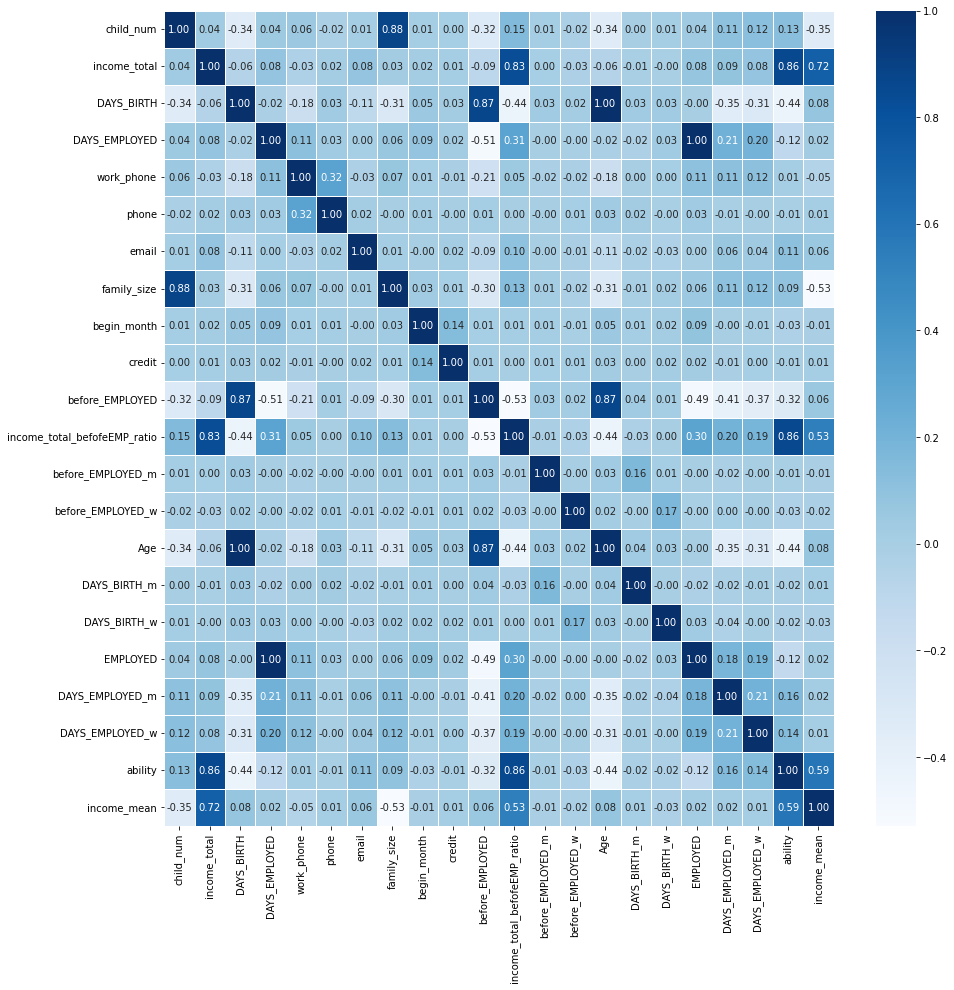

In [100]:
corr = train.corr(method='pearson')
plt.figure(figsize=(15,15))
sns.heatmap(data=corr, annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')

<AxesSubplot:>

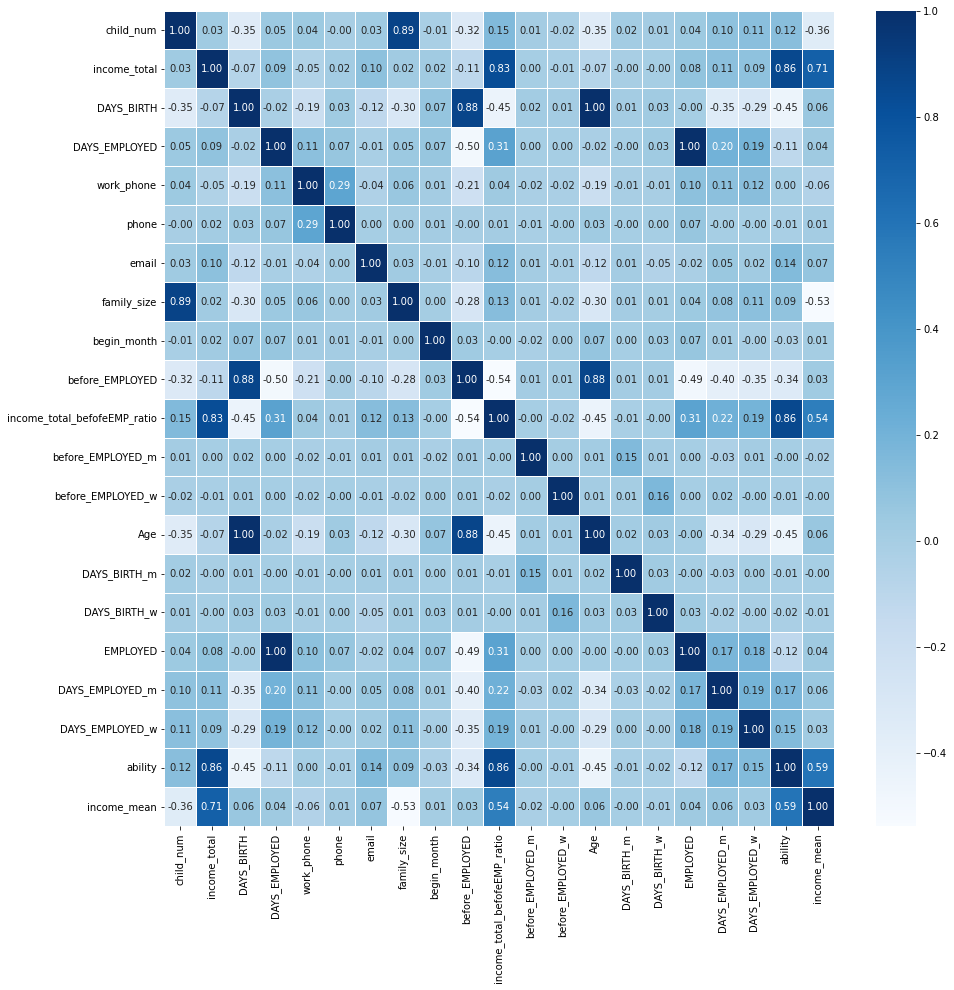

In [101]:
test_corr = test.corr(method='pearson')
plt.figure(figsize=(15,15))
sns.heatmap(data=test_corr, annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')

### **파생변수와 다중공선을 보이는 컬럼 삭제**

In [102]:
cols = ['child_num', 'DAYS_BIRTH', 'DAYS_EMPLOYED']
# df.drop(cols, axis=1, inplace=True)
train.drop(cols, axis=1, inplace=True)
test.drop(cols, axis=1, inplace=True)

## **Scaling, Encoding**

### **1. Numerical, Categorical 컬럼 분류**

In [103]:
numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()

numerical_feats.remove('credit')
numerical_feats.remove('work_phone')
numerical_feats.remove('phone')
numerical_feats.remove('email')

print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = train.dtypes[train.dtypes == "object"].index.tolist()
categorical_feats.append('work_phone')
categorical_feats.append('phone')
categorical_feats.append('email')
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  15
Number of Categorical features:  12


In [104]:
numerical_feats

['income_total',
 'family_size',
 'begin_month',
 'before_EMPLOYED',
 'income_total_befofeEMP_ratio',
 'before_EMPLOYED_m',
 'before_EMPLOYED_w',
 'Age',
 'DAYS_BIRTH_m',
 'DAYS_BIRTH_w',
 'EMPLOYED',
 'DAYS_EMPLOYED_m',
 'DAYS_EMPLOYED_w',
 'ability',
 'income_mean']

In [105]:
categorical_feats

['gender',
 'car',
 'reality',
 'income_type',
 'edu_type',
 'family_type',
 'house_type',
 'occyp_type',
 'ID',
 'work_phone',
 'phone',
 'email']

In [106]:
# train[categorical_feats] = train[categorical_feats].astype('category')

### **2. Log Scaling**

*   income_total



In [107]:
for df in [train,test]:
    df['income_total'] = np.log1p(1+df['income_total'])

In [108]:
train.describe()

,income_total,work_phone,phone,email,family_size,begin_month,credit,before_EMPLOYED,income_total_befofeEMP_ratio,before_EMPLOYED_m,before_EMPLOYED_w,Age,DAYS_BIRTH_m,DAYS_BIRTH_w,EMPLOYED,DAYS_EMPLOYED_m,DAYS_EMPLOYED_w,ability,income_mean
count,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000,17371.000000
mean,12.020583,0.225951,0.295838,0.091877,2.188533,25.945311,1.509815,13747.813770,15.535618,5.457487,1.510794,43.210811,5.469921,1.499050,5.640665,4.579184,1.257095,11.084466,101225.093070
std,0.480659,0.418219,0.456432,0.288861,0.895699,16.556260,0.707110,4880.417598,10.296112,3.417380,1.124867,11.543510,3.449070,1.118349,6.463774,3.735034,1.166551,6.756070,73184.296911
min,10.203666,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,6547.000000,1.268406,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.235488,7560.000000
25%,11.707686,0.000000,0.000000,0.000000,2.000000,12.000000,1.000000,9646.000000,8.548594,3.000000,0.000000,34.000000,3.000000,0.000000,1.000000,1.000000,0.000000,6.505426,56250.000000
50%,11.967193,0.000000,0.000000,0.000000,2.000000,24.000000,2.000000,12679.000000,13.418001,5.000000,2.000000,42.000000,5.000000,2.000000,4.000000,4.000000,1.000000,9.677419,78750.000000
75%,12.323865,0.000000,1.000000,0.000000,3.000000,39.000000,2.000000,17006.000000,19.808518,8.000000,3.000000,53.000000,8.000000,2.000000,8.000000,8.000000,2.000000,13.902579,126000.000000
max,14.269767,1.000000,1.000000,1.000000,7.000000,60.000000,2.000000,25152.000000,205.533081,11.000000,3.000000,68.000000,11.000000,3.000000,43.000000,11.000000,3.000000,124.792013,900000.000000


### **3. Standard Scaling**

* 이미 로그스케일링을 진행한 income_total을 제외한 나머지 수치형 컬럼 정규화

In [109]:
numerical_feats.remove('income_total')
scaler = StandardScaler()
train[numerical_feats] = scaler.fit_transform(train[numerical_feats])
test[numerical_feats] = scaler.transform(test[numerical_feats])

In [111]:
train[numerical_feats].describe()

,family_size,begin_month,before_EMPLOYED,income_total_befofeEMP_ratio,before_EMPLOYED_m,before_EMPLOYED_w,Age,DAYS_BIRTH_m,DAYS_BIRTH_w,EMPLOYED,DAYS_EMPLOYED_m,DAYS_EMPLOYED_w,ability,income_mean
count,1.737100e+04,1.737100e+04,1.737100e+04,1.737100e+04,1.737100e+04,1.737100e+04,1.737100e+04,1.737100e+04,1.737100e+04,1.737100e+04,1.737100e+04,1.737100e+04,1.737100e+04,1.737100e+04
mean,-4.685325e-16,-4.200965e-17,1.010008e-16,5.852143e-17,-1.347658e-16,-2.096456e-16,1.021175e-15,-3.333162e-16,-8.102947e-16,-2.272167e-17,1.088685e-16,3.766871e-16,1.181350e-16,4.475501e-16
std,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00
min,-1.326971e+00,-1.567145e+00,-1.475493e+00,-1.385729e+00,-1.597026e+00,-1.343125e+00,-1.924151e+00,-1.585957e+00,-1.340452e+00,-8.726834e-01,-1.226044e+00,-1.077648e+00,-1.457839e+00,-1.279889e+00
25%,-2.104926e-01,-8.423227e-01,-8.404879e-01,-6.786276e-01,-7.191348e-01,-1.343125e+00,-7.979442e-01,-7.161327e-01,-1.340452e+00,-7.179705e-01,-9.583009e-01,-1.077648e+00,-6.777863e-01,-6.145634e-01
50%,-2.104926e-01,-1.175004e-01,-2.190068e-01,-2.056774e-01,-1.338744e-01,4.349137e-01,-1.048941e-01,-1.362497e-01,4.479499e-01,-2.538320e-01,-1.550723e-01,-2.203955e-01,-2.082700e-01,-3.071115e-01
75%,9.059857e-01,7.885274e-01,6.676232e-01,4.150133e-01,7.440162e-01,1.323933e+00,8.480498e-01,7.335749e-01,4.479499e-01,3.650193e-01,9.158992e-01,6.368570e-01,4.171352e-01,3.385374e-01
max,5.371899e+00,2.056966e+00,2.336791e+00,1.845385e+01,1.621907e+00,1.323933e+00,2.147519e+00,1.603400e+00,1.342151e+00,5.779969e+00,1.719128e+00,1.494110e+00,1.683091e+01,1.091488e+01


### **4. Clustering 구성**

*   target을 결정 짓는 뚜렷한 특징을 갖는 피쳐를 찾기 위해 clustering 생성



In [21]:
kprototypes_train = train.drop(['credit'], axis=1)

In [22]:
categorical_indexes = []
for c in categorical_feats:
    categorical_indexes.append(kprototypes_train.columns.get_loc(c))
categorical_indexes

[0, 1, 2, 4, 5, 6, 7, 11, 26, 8, 9, 10]

In [23]:
# we set the number of clusters to 3
kproto = KPrototypes(n_clusters= 5, init='Huang', random_state=42, n_jobs=-1)
kproto.fit(kprototypes_train, categorical= categorical_indexes)

train['cluster'] = kproto.predict(kprototypes_train, categorical= categorical_indexes)
test['cluster'] = kproto.predict(test, categorical= categorical_indexes)

## **Over Sampling**

* target이 imbalanced하기에 오버 샘플링 진행
* 수치형 변수와 범주형 변수가 모두 있기에 SMOTENC를 적용

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17371 entries, 0 to 17370
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gender                        17371 non-null  object 
 1   car                           17371 non-null  object 
 2   reality                       17371 non-null  object 
 3   income_total                  17371 non-null  float64
 4   income_type                   17371 non-null  object 
 5   edu_type                      17371 non-null  object 
 6   family_type                   17371 non-null  object 
 7   house_type                    17371 non-null  object 
 8   work_phone                    17371 non-null  int64  
 9   phone                         17371 non-null  int64  
 10  email                         17371 non-null  int64  
 11  occyp_type                    17371 non-null  object 
 12  family_size                   17371 non-null  float64
 13  b

In [25]:
X_train = train.drop(labels=['credit'], axis=1)
y_train = train['credit']

In [26]:
X_train.columns

Index(['gender', 'car', 'reality', 'income_total', 'income_type', 'edu_type',
       'family_type', 'house_type', 'work_phone', 'phone', 'email',
       'occyp_type', 'family_size', 'begin_month', 'before_EMPLOYED',
       'income_total_befofeEMP_ratio', 'before_EMPLOYED_m',
       'before_EMPLOYED_w', 'Age', 'DAYS_BIRTH_m', 'DAYS_BIRTH_w', 'EMPLOYED',
       'DAYS_EMPLOYED_m', 'DAYS_EMPLOYED_w', 'ability', 'income_mean', 'ID',
       'cluster'],
      dtype='object')

In [27]:
categorical_indexes = []
for c in categorical_feats:
    categorical_indexes.append(X_train.columns.get_loc(c))
categorical_indexes

[0, 1, 2, 4, 5, 6, 7, 11, 26, 8, 9, 10]

In [28]:
# SMOTENC 모델 설정
smotenc = SMOTENC(categorical_features= categorical_indexes,random_state = 42, k_neighbors= 5)
X_train_res, y_train_res = smotenc.fit_resample(X_train, y_train)

print('Before Resampled dataset shape %s' % Counter(y_train))
print('After Resampled dataset shape %s' % Counter(y_train_res))

Before Resampled dataset shape Counter({2.0: 11028, 1.0: 4171, 0.0: 2172})
After Resampled dataset shape Counter({2.0: 11028, 1.0: 11028, 0.0: 11028})


In [29]:
y_train.value_counts()

2.0    11028
1.0     4171
0.0     2172
Name: credit, dtype: int64

In [30]:
y_train_res.value_counts()

2.0    11028
1.0    11028
0.0    11028
Name: credit, dtype: int64

## **Modeling - CatboostClassifier**

* fold 수를 5부터 17까지 돌려보고 최적 fold 15로 판단 후 선택



In [31]:
n_est = 2000
seed = 42
n_fold = 5
n_class = 3

target = 'credit'
X = X_train_res
y = y_train_res
X_test = test

In [32]:
categorical_feats.remove('work_phone')
categorical_feats.remove('phone')
categorical_feats.remove('email')

In [33]:
categorical_feats

['gender',
 'car',
 'reality',
 'income_type',
 'edu_type',
 'family_type',
 'house_type',
 'occyp_type',
 'ID']

In [34]:
from sklearn.metrics import classification_report

skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], 1))
cat_pred_test = np.zeros((X_test.shape[0], 1))

cat_pred_proba = np.zeros((X.shape[0], n_class))
cat_pred_proba_test = np.zeros((X_test.shape[0], n_class))

# cat_cols = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID']
for fold in tqdm(range(n_fold)):
  print(f'\n----------------- Fold {fold} -----------------\n')
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
  train_data = Pool(data=X_train, label=y_train, cat_features=categorical_feats)
  valid_data = Pool(data=X_valid, label=y_valid, cat_features=categorical_feats)
#   train_data = Pool(data=X_train, label=y_train)
#   valid_data = Pool(data=X_valid, label=y_valid)

  model_cat = CatBoostClassifier(n_estimators=n_est,random_seed=seed, bootstrap_type ='Bernoulli')
  model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)
  
  cat_pred[valid_idx] = model_cat.predict(X_valid)

  cat_pred_proba[valid_idx] = model_cat.predict_proba(X_valid)
  cat_pred_proba_test += model_cat.predict_proba(X_test) / n_fold
  print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred_proba[valid_idx]):.6f}')
  time.sleep(1)
  
print(f'\nLog Loss: {log_loss(y, cat_pred_proba):.6f}')

  0%|          | 0/5 [00:00<?, ?it/s]


----------------- Fold 0 -----------------

Learning rate set to 0.088468
0:	learn: 1.0241898	test: 1.0161545	best: 1.0161545 (0)	total: 93.7ms	remaining: 3m 7s
100:	learn: 0.5291535	test: 0.4688270	best: 0.4688270 (100)	total: 2.28s	remaining: 42.8s
200:	learn: 0.4871156	test: 0.4431498	best: 0.4431205 (199)	total: 4.88s	remaining: 43.6s
300:	learn: 0.4668108	test: 0.4358503	best: 0.4358503 (300)	total: 7.33s	remaining: 41.4s
400:	learn: 0.4509955	test: 0.4318871	best: 0.4318871 (400)	total: 10.1s	remaining: 40.1s
500:	learn: 0.4357531	test: 0.4273102	best: 0.4273102 (500)	total: 13.1s	remaining: 39.1s
600:	learn: 0.4223566	test: 0.4244581	best: 0.4244581 (600)	total: 15.6s	remaining: 36.3s
700:	learn: 0.4098861	test: 0.4231246	best: 0.4230495 (695)	total: 18.1s	remaining: 33.5s
800:	learn: 0.3982743	test: 0.4222519	best: 0.4222103 (774)	total: 20.5s	remaining: 30.7s
900:	learn: 0.3859200	test: 0.4202332	best: 0.4201017 (892)	total: 23s	remaining: 28.1s
1000:	learn: 0.3751538	test: 0

1600:	learn: 0.3221293	test: 0.3991551	best: 0.3990088 (1549)	total: 38.6s	remaining: 9.63s
1700:	learn: 0.3135706	test: 0.3986634	best: 0.3984978 (1656)	total: 41.1s	remaining: 7.22s
1800:	learn: 0.3054618	test: 0.3982094	best: 0.3979789 (1791)	total: 43.6s	remaining: 4.82s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3979789203
bestIteration = 1791

Shrink model to first 1792 iterations.
CV Log Loss Score: 0.397979

Log Loss: 0.408876


## **Model 평가**

### **1. Valid data 평가**

In [35]:
# Valid Score

print(f'\nValid Accuracy Score: {accuracy_score(y, cat_pred):.6f}')
print(f"Valid F1 Score:  {f1_score(y, cat_pred, average='macro'):.6f}")
print(f'Valid Log Loss: {log_loss(y, cat_pred_proba):.6f}')
print(f"\nValid ROC_AUC_Score: {roc_auc_score(y, cat_pred_proba, multi_class='ovr'):.6f}")

print('\nclassification_report - valid data')
print(classification_report(y, cat_pred))

print('\nConfusion_matrix - valid data')
print(confusion_matrix(y, cat_pred))

print('\nConfusion_matrix_Normalize - valid data')
print(confusion_matrix(y, cat_pred, normalize='true'))


Valid Accuracy Score: 0.849444
Valid F1 Score:  0.849446
Valid Log Loss: 0.408876

Valid ROC_AUC_Score: 0.950088

classification_report - valid data
              precision    recall  f1-score   support

         0.0       0.88      0.89      0.89     11028
         1.0       0.86      0.81      0.83     11028
         2.0       0.80      0.85      0.83     11028

    accuracy                           0.85     33084
   macro avg       0.85      0.85      0.85     33084
weighted avg       0.85      0.85      0.85     33084


Confusion_matrix - valid data
[[9806  476  746]
 [ 605 8886 1537]
 [ 671  946 9411]]

Confusion_matrix_Normalize - valid data
[[0.88919115 0.04316286 0.06764599]
 [0.05486036 0.80576714 0.13937251]
 [0.06084512 0.08578165 0.85337323]]


### **Validation Set Confusion Matrix 시각화**

In [36]:
cm = confusion_matrix(y,cat_pred)

cm_df = pd.DataFrame(cm, index = ['0','1','2'], columns = ['0','1','2'])

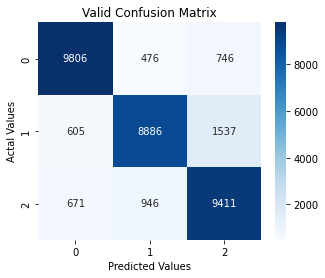

In [37]:
# Confusion Matrix (갯수)
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Valid Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [38]:
cm_normalize = confusion_matrix(y,cat_pred, normalize='true')

normalize_cm_df = pd.DataFrame(cm_normalize, index = ['0','1','2'], columns = ['0','1','2'])

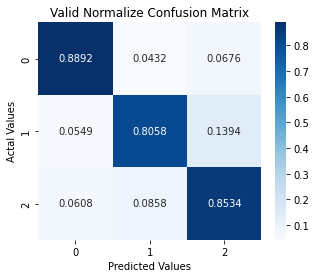

In [39]:
# Confusion Matrix (비율)
plt.figure(figsize=(5,4))
sns.heatmap(normalize_cm_df, annot=True, fmt='.4f',cmap='Blues')
plt.title('Valid Normalize Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show() 

### **2. Test data 평가**

In [40]:
# Test Score
cat_pred_test = model_cat.predict(X_test)

print(f'\nTest Accuracy Score: {accuracy_score(y_test, cat_pred_test):.6f}')
print(f"Test F1 Score:  {f1_score(y_test, cat_pred_test, average='macro'):.6f}")
print(f'Test Log Loss: {log_loss(y_test, cat_pred_proba_test):.6f}')
print(f"\nTest ROC_AUC_Score: {roc_auc_score(y_test, cat_pred_proba_test, multi_class='ovr'):.6f}")

print('\nclassification_report - Test data')
print(classification_report(y_test, cat_pred_test))

print('\nConfusion_matrix - Test data')
print(confusion_matrix(y_test, cat_pred_test))

print('\nConfusion_matrix_Normalize - Test data')
print(confusion_matrix(y_test, cat_pred_test, normalize='true'))


Test Accuracy Score: 0.691647
Test F1 Score:  0.559908
Test Log Loss: 0.770596

Test ROC_AUC_Score: 0.752031

classification_report - Test data
              precision    recall  f1-score   support

         0.0       0.42      0.33      0.37       888
         1.0       0.56      0.46      0.51      1762
         2.0       0.76      0.84      0.80      4796

    accuracy                           0.69      7446
   macro avg       0.58      0.55      0.56      7446
weighted avg       0.67      0.69      0.68      7446


Confusion_matrix - Test data
[[ 296  130  462]
 [ 145  809  808]
 [ 258  493 4045]]

Confusion_matrix_Normalize - Test data
[[0.33333333 0.1463964  0.52027027]
 [0.08229285 0.45913734 0.45856981]
 [0.05379483 0.10279399 0.84341118]]


### **Test Set Confusion Matrix 시각화**

In [41]:
cm_test = confusion_matrix(y_test,cat_pred_test)

cm_test_df = pd.DataFrame(cm_test, index = ['0','1','2'], columns = ['0','1','2'])

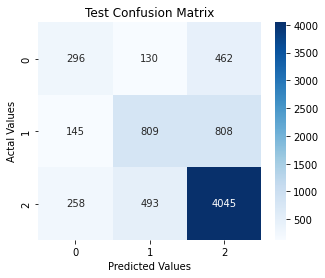

In [42]:
# Test Set Confusion Matrix (갯수)
plt.figure(figsize=(5,4))
sns.heatmap(cm_test_df, annot=True, fmt='d', cmap='Blues')
plt.title('Test Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [43]:
cm_test_normalize = confusion_matrix(y_test, cat_pred_test, normalize='true')

normalize_cm_test_df = pd.DataFrame(cm_test_normalize, index = ['0','1','2'], columns = ['0','1','2'])

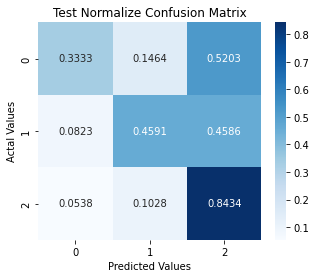

In [44]:
# Test Set Confusion Matrix (비율)
plt.figure(figsize=(5,4))
sns.heatmap(normalize_cm_test_df, annot=True, fmt='.4f', cmap='Blues')
plt.title('Test Normalize Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

## **Feature Importance**

In [45]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    
    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

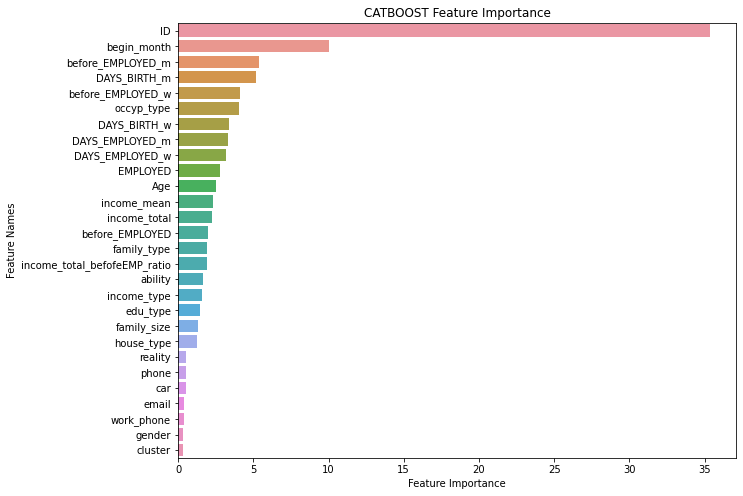

In [46]:
plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')

In [47]:
! pip install shap

You should consider upgrading via the '/opt/conda/bin/python3.8 -m pip install --upgrade pip' command.


In [48]:
# shapley
import shap

In [49]:
explainer = shap.TreeExplainer(model_cat)
shap_values = explainer.shap_values(Pool(X, y, cat_features=categorical_feats))

In [50]:
X.values[0]

array(['F', 'N', 'Y', 11.302229124707774, 'Commercial associate',
       'Secondary / secondary special', 'Single / not married',
       'House / apartment', 0, 0, 0, 'Medicine staff', -1.326970802599187,
       -0.661117092405982, -1.324681695457857, -0.428701082915246,
       -1.011765067049687, -1.3431247747261195, -1.4043629655586916,
       -0.42619118818297475, -0.4462511576286325, 0.2103065043824938,
       -0.6905580697804143, -0.22039546913354557, -0.6776203969867124,
       -0.27636632583193366,
       'F_9866_81000.0_Commercial associate_Secondary / secondary special_Medicine staff',
       1], dtype=object)

In [51]:
X.iloc[0]

gender                                                                          F
car                                                                             N
reality                                                                         Y
income_total                                                            11.302229
income_type                                                  Commercial associate
edu_type                                            Secondary / secondary special
family_type                                                  Single / not married
house_type                                                      House / apartment
work_phone                                                                      0
phone                                                                           0
email                                                                           0
occyp_type                                                         Medicine staff
family_size     

In [52]:
y.iloc[0]

2.0

## SHAP Explanation Force Plots 

-	화살표가 클수록 output에 미치는 영향도 커짐

In [53]:
# SHAP Explanation Force Plots 
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], X.iloc[0], feature_names = X.columns)

In [54]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], X.iloc[0], feature_names = X.columns)

In [55]:
shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0], X.iloc[0], feature_names = X.columns)

## SHAP waterfall plot

-	예측을 높게 해주는 변수는 빨간색으로 표시하고, 예측을 낮게 해주는 변수는 파란색으로 표시
-	학습 데이터셋에 대한 평균 모델 결과값으로부터 산출된 모델 결과를 최종 모델 결과로 산출하는 것에 대한 변수들의 공헌도

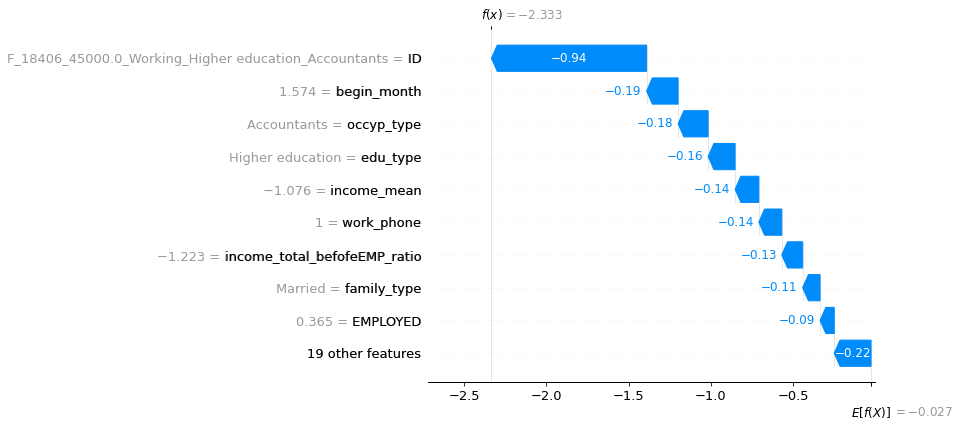

In [67]:
row = len(X.columns)
shap.waterfall_plot(shap.Explanation(values=shap_values[0][row], 
                                              base_values=explainer.expected_value[0], data=X.iloc[row],  
                                         feature_names=X.columns.tolist()))

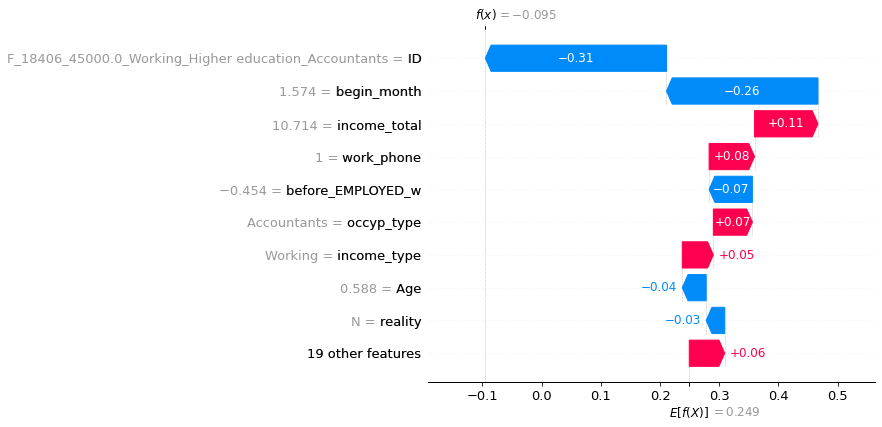

In [68]:
row = len(X.columns)
shap.waterfall_plot(shap.Explanation(values=shap_values[1][row], 
                                              base_values=explainer.expected_value[1], data=X.iloc[row],  
                                         feature_names=X.columns.tolist()))

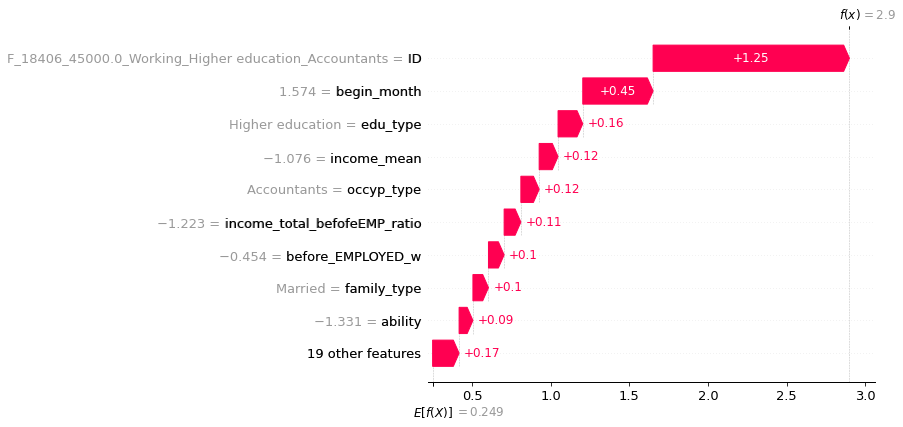

In [69]:
row = len(X.columns)
shap.waterfall_plot(shap.Explanation(values=shap_values[2][row], 
                                              base_values=explainer.expected_value[1], data=X.iloc[row],  
                                         feature_names=X.columns.tolist()))

## SHAP Summary plot

-	feature importance와 feature effects 결합
-	전체 특성들이 Shapley value 분포에 어떤 영향을 미치는지 시각화하는 것
-	파란색 : 특성 값이 작다 / 빨간색 : 특성 값이 크다.
-	SHAP value가 큰 것 == 예측에 긍정적인 영향을 미친다.
> SHAP values : 가능한 모든 조합을 고려한 후 한 플레이어의 평균 기대 한계 기여도이다
-	‘begin_month’ column을 보면 특성값이 작을수록(파란색) 긍정적인 영향을 미치고 있다.

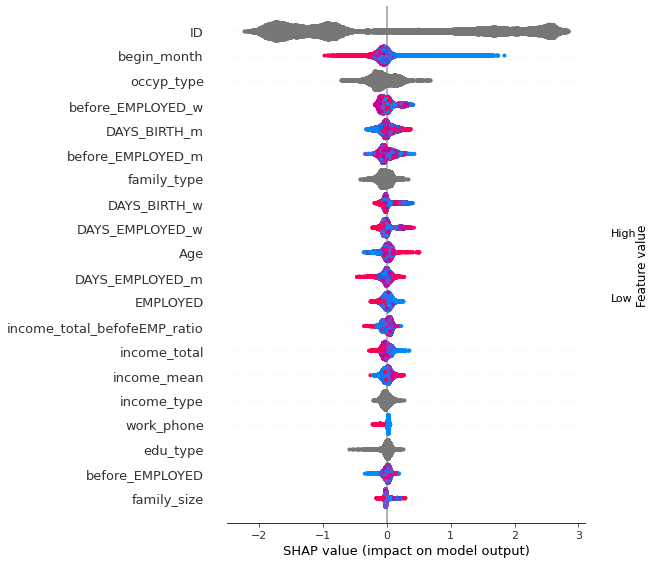

In [59]:
shap.summary_plot(shap_values[0], X)

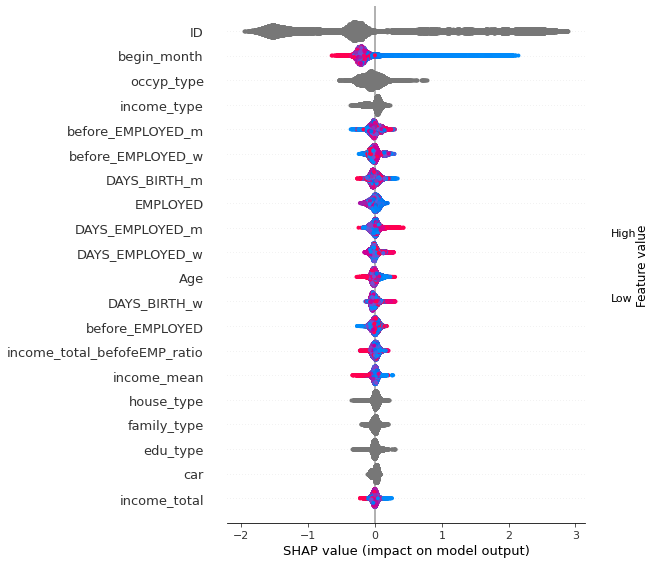

In [60]:
shap.summary_plot(shap_values[1], X)

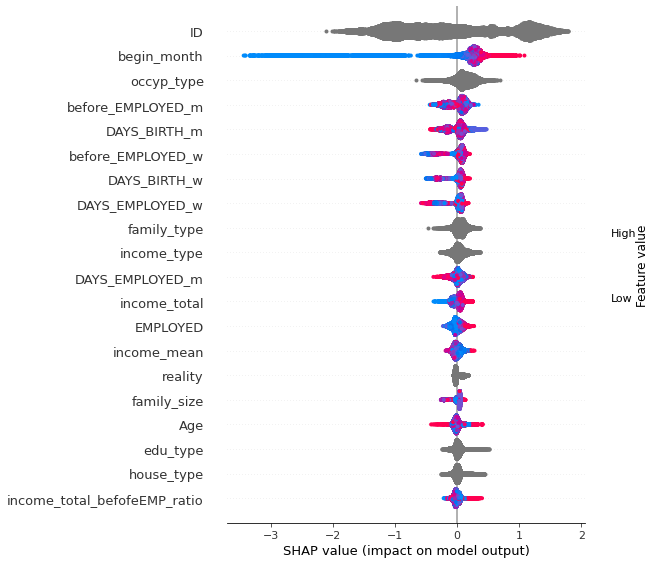

In [61]:
shap.summary_plot(shap_values[2], X)

## SHAP Feature Importance

-	summary_plot을 사용하되 파라미터로 plot_type을 정해주면 각 특성이 모델에 미치는 절대영향도(=기여분)을 눈으로 파악할 수 있다.

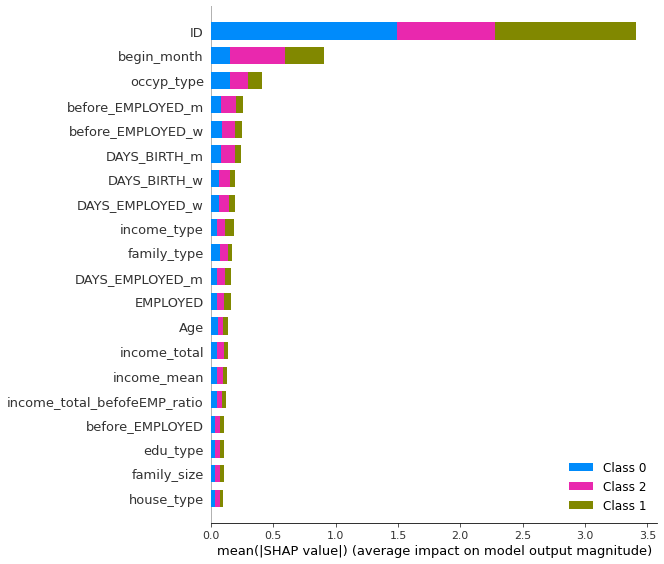

In [62]:
shap.summary_plot(shap_values, X)

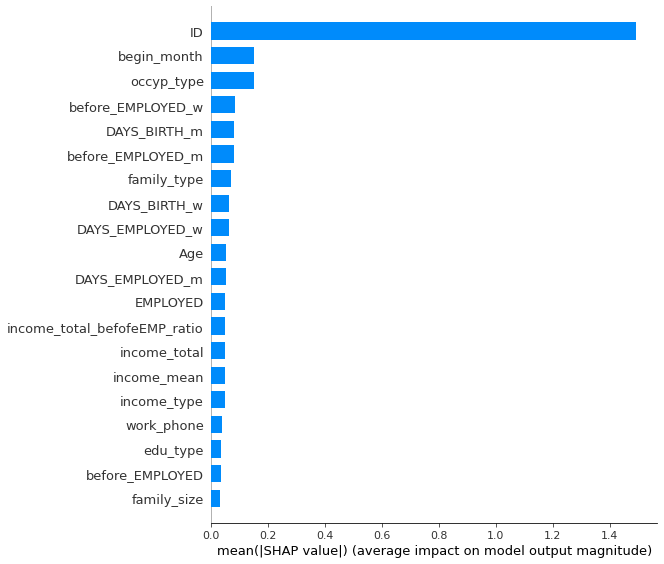

In [63]:
shap.summary_plot(shap_values[0], X, plot_type='bar')

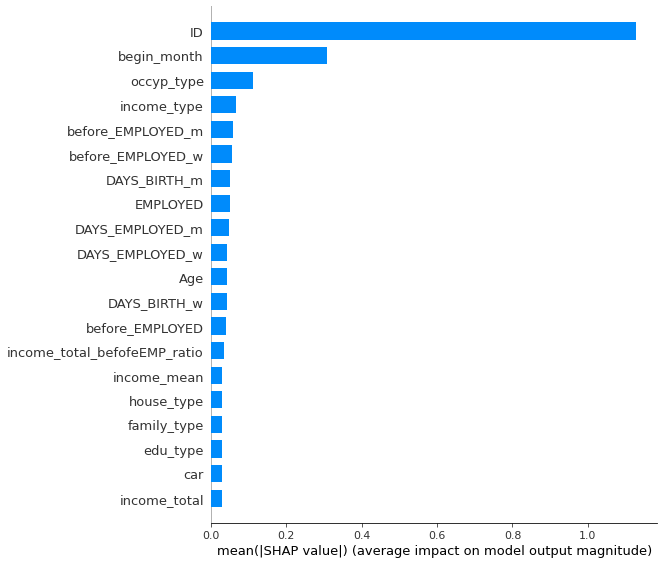

In [64]:
shap.summary_plot(shap_values[1], X, plot_type='bar')

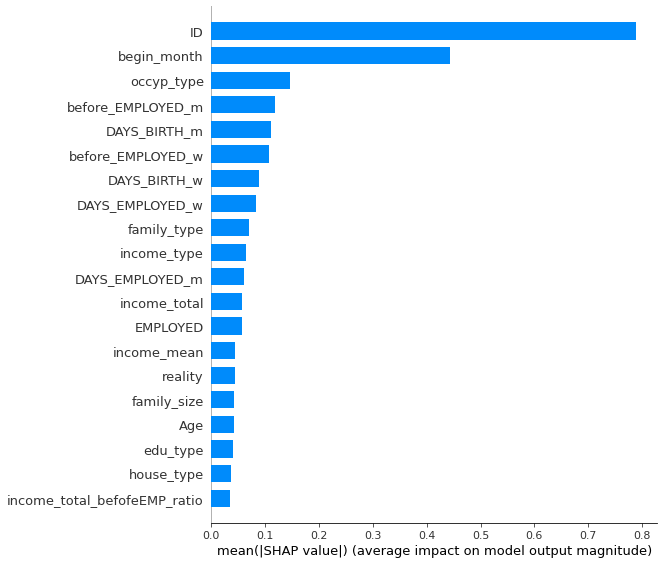

In [65]:
shap.summary_plot(shap_values[2], X, plot_type='bar')

## SHAP Dependence Plot

- dependence_plot 을 통해 각 특성의 Shapely value를 확인할 수 있음

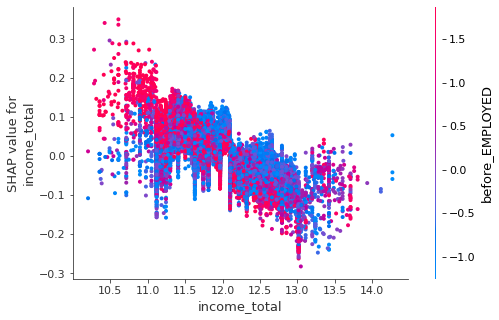

In [83]:
shap.initjs()
shap.dependence_plot(3, shap_values[0], X.values, feature_names=X.columns)

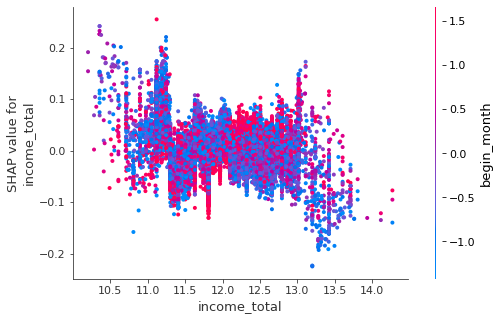

In [87]:
shap.dependence_plot(3, shap_values[1], X.values, feature_names=X.columns)